# Time Series Forecasting Model
Predict next day’s Open and Close prices

Based on past N days of data for one company at a time
Using a GRU or LSTM model.

In [ ]:
from google.colab import files

# Open a file upload dialog
uploaded = files.upload()

Saving World-Stock-Prices-Dataset.csv to World-Stock-Prices-Dataset.csv


# **Importing neccessary libraries**

In [ ]:
!pip install torchinfo
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt


**Saving Dataset to df**

In [ ]:
df = pd.read_csv('World-Stock-Prices-Dataset.csv')
head = df.head(10)
print(f"Top rows of dataset: {head}")
print("Nulls per column:")
print(df.isnull().sum())

Top rows of dataset:                         Date        Open        High         Low       Close  \
0  2025-07-03 00:00:00-04:00    6.630000    6.740000    6.615000    6.640000   
1  2025-07-03 00:00:00-04:00  106.750000  108.370003  106.330101  107.339996   
2  2025-07-03 00:00:00-04:00  122.629997  123.050003  121.550003  121.930000   
3  2025-07-03 00:00:00-04:00  221.705002  224.009995  221.360001  223.410004   
4  2025-07-03 00:00:00-04:00  212.145004  214.649994  211.810104  213.550003   
5  2025-07-03 00:00:00-04:00   76.264999   77.029999   75.580002   76.389999   
6  2025-07-03 00:00:00-04:00  105.949997  105.969902  104.055000  104.059998   
7  2025-07-03 00:00:00-04:00  178.695007  179.669998  177.059998  179.529999   
8  2025-07-03 00:00:00-04:00  713.000000  725.549988  704.549988  725.049988   
9  2025-07-03 00:00:00-04:00   77.599998   79.824997   77.410004   78.580002   

       Volume                 Brand_Name Ticker Industry_Tag  Country  \
0   4209664.0            

**Filter Data for One Company**

In [ ]:
df = df[df['Ticker'] == 'AAPL']  # Ticker for Amazon
df = df.sort_values('Date')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Only needed columns


# **Normalize the Data**

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

#  Create Sequences (30 days → next day [Open, Close])

In [ ]:
SEQ_LENGTH = 30

X = []
y = []

for i in range(SEQ_LENGTH, len(scaled_df)):
    X.append(scaled_df.iloc[i-SEQ_LENGTH:i].values)
    y.append(scaled_df.iloc[i][[0, 3]].values)  # Open and Close

X = np.array(X)
y = np.array(y)


/tmp/ipython-input-3506096969.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(scaled_df.iloc[i][[0, 3]].values)  # Open and Close


**Create PyTorch Dataset**

In [ ]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data
train_size = int(len(X) * 0.8)
train_dataset = StockDataset(X[:train_size], y[:train_size])
test_dataset = StockDataset(X[train_size:], y[train_size:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# Build GRU Model in PyTorch

In [ ]:
from torchinfo import summary
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

model = GRUModel(input_size=5, hidden_size=64, num_layers=2, output_size=2)
summary(model, input_size=(32, 30, 5))

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [32, 2]                   --
├─GRU: 1-1                               [32, 30, 64]              38,592
├─Linear: 1-2                            [32, 2]                   130
Total params: 38,722
Trainable params: 38,722
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 37.05
Input size (MB): 0.02
Forward/backward pass size (MB): 0.49
Params size (MB): 0.15
Estimated Total Size (MB): 0.67

**Train the Model**

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000


**Evaluate & Plot**

MSE for Open Price: 92.5665
MSE for Close Price: 93.3260


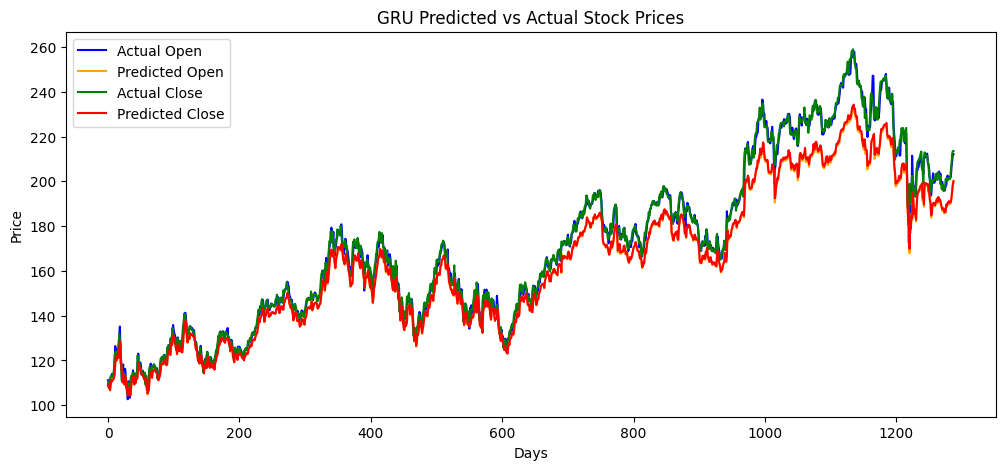

In [ ]:
from sklearn.metrics import mean_squared_error
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.append(pred.numpy().flatten())
        actuals.append(y_batch.numpy().flatten())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Inverse transform to original scale
# Fill dummy values for the other 3 features (High, Low, Volume)
def rescale(preds_2col):
    # preds_2col is shape [N, 2] → [Open, Close]
    open_col = preds_2col[:, 0].reshape(-1, 1)
    close_col = preds_2col[:, 1].reshape(-1, 1)
    dummy = np.zeros((preds_2col.shape[0], 3))  # High, Low, Volume

    # Reconstruct full 5-column input: [Open, High, Low, Close, Volume]
    merged = np.hstack([open_col, dummy[:, 0:1], dummy[:, 1:2], close_col, dummy[:, 2:3]])
    return scaler.inverse_transform(merged)[:, [0, 3]]  # Only get Open and Close

# Apply to both actual and predicted
pred_rescaled = rescale(predictions)
actual_rescaled = rescale(actuals)

# Calculate MSE
mse_open = mean_squared_error(actual_rescaled[:, 0], pred_rescaled[:, 0])
mse_close = mean_squared_error(actual_rescaled[:, 1], pred_rescaled[:, 1])
print(f"MSE for Open Price: {mse_open:.4f}")
print(f"MSE for Close Price: {mse_close:.4f}")

#Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_rescaled[:, 0], label='Actual Open', color='blue')
plt.plot(pred_rescaled[:, 0], label='Predicted Open', color='orange')
plt.plot(actual_rescaled[:, 1], label='Actual Close', color='green')
plt.plot(pred_rescaled[:, 1], label='Predicted Close', color='red')
plt.legend()
plt.title("GRU Predicted vs Actual Stock Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [ ]:
for i in range(5):
    print(f"Actual Open: {actual_rescaled[i,0]:.2f}, Pred Open: {pred_rescaled[i,0]:.2f} | "
          f"Actual Close: {actual_rescaled[i,1]:.2f}, Pred Close: {pred_rescaled[i,1]:.2f}")

Actual Open: 111.20, Pred Open: 109.44 | Actual Close: 109.14, Pred Close: 108.93
Actual Open: 110.60, Pred Open: 107.92 | Actual Close: 110.73, Pred Close: 107.89
Actual Open: 109.98, Pred Open: 109.30 | Actual Close: 107.43, Pred Close: 108.93
Actual Open: 108.54, Pred Open: 106.66 | Actual Close: 111.00, Pred Close: 106.71
Actual Open: 112.40, Pred Open: 109.38 | Actual Close: 112.97, Pred Close: 108.86


**LSTM Model**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden)
        out = self.fc(out[:, -1, :])     # Take last output for prediction
        return out


**Train the Model**

In [ ]:
# Initialize model
lstm_model = LSTMModel(input_size=5, hidden_size=64, num_layers=2, output_size=2)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Train
num_epochs = 50
lstm_model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"[LSTM] Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

[LSTM] Epoch [10/50], Loss: 0.0000
[LSTM] Epoch [20/50], Loss: 0.0000
[LSTM] Epoch [30/50], Loss: 0.0000
[LSTM] Epoch [40/50], Loss: 0.0000
[LSTM] Epoch [50/50], Loss: 0.0000


**Evaluate the LSTM Model**

MSE for Open Price: 12.1785
MSE for Close Price: 13.7351


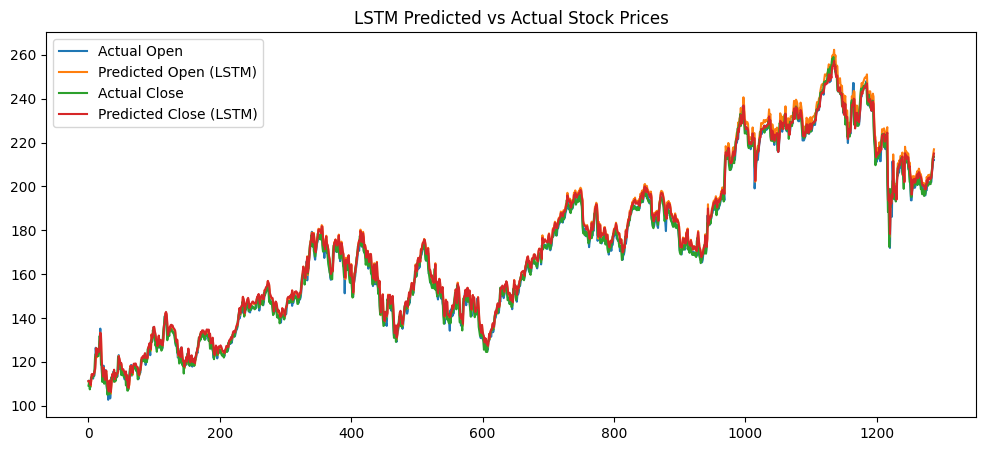

In [ ]:
from sklearn.metrics import mean_squared_error

lstm_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = lstm_model(X_batch)
        predictions.append(pred.numpy().flatten())
        actuals.append(y_batch.numpy().flatten())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Inverse transform to original scale
def rescale(preds_2col):
    # preds_2col is shape [N, 2] → [Open, Close]
    open_col = preds_2col[:, 0].reshape(-1, 1)
    close_col = preds_2col[:, 1].reshape(-1, 1)
    dummy = np.zeros((preds_2col.shape[0], 3))  # High, Low, Volume

    # Reconstruct full 5-column input: [Open, High, Low, Close, Volume]
    merged = np.hstack([open_col, dummy[:, 0:1], dummy[:, 1:2], close_col, dummy[:, 2:3]])
    return scaler.inverse_transform(merged)[:, [0, 3]]  # Only get Open and Close

# Apply to both actual and predicted
pred_rescaled = rescale(predictions)
actual_rescaled = rescale(actuals)

# Calculate MSE
mse_open = mean_squared_error(actual_rescaled[:, 0], pred_rescaled[:, 0])
mse_close = mean_squared_error(actual_rescaled[:, 1], pred_rescaled[:, 1])
print(f"MSE for Open Price: {mse_open:.4f}")
print(f"MSE for Close Price: {mse_close:.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_rescaled[:, 0], label='Actual Open')
plt.plot(pred_rescaled[:, 0], label='Predicted Open (LSTM)')
plt.plot(actual_rescaled[:, 1], label='Actual Close')
plt.plot(pred_rescaled[:, 1], label='Predicted Close (LSTM)')
plt.legend()
plt.title("LSTM Predicted vs Actual Stock Prices")
plt.show()

**Comparing the GRU and LSTM models using Evaluation Metrics**

In [ ]:
for i in range(5):
    print(f"Actual Open: {actual_rescaled[i,0]:.2f}, Pred Open: {pred_rescaled[i,0]:.2f} | "
          f"Actual Close: {actual_rescaled[i,1]:.2f}, Pred Close: {pred_rescaled[i,1]:.2f}")

Actual Open: 111.20, Pred Open: 110.95 | Actual Close: 109.14, Pred Close: 111.26
Actual Open: 110.60, Pred Open: 110.21 | Actual Close: 110.73, Pred Close: 110.86
Actual Open: 109.98, Pred Open: 110.73 | Actual Close: 107.43, Pred Close: 111.28
Actual Open: 108.54, Pred Open: 108.61 | Actual Close: 111.00, Pred Close: 109.39
Actual Open: 112.40, Pred Open: 110.86 | Actual Close: 112.97, Pred Close: 111.20


**Saving the model to .pth**

In [ ]:
# Save the model weights (state_dict)
torch.save(lstm_model.state_dict(), 'lstm_model_weights.pth')

**Load the model later for deployment**

In [ ]:
import torch
import torch.nn as nn

# First, re-import (or re-define) the model class you used during training
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters (must match training)
input_size = 5       # Open, High, Low, Close, Volume
hidden_size = 64
num_layers = 2
output_size = 2      # Open & Close predictions

# Recreate the model instance
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Load trained weights
model.load_state_dict(torch.load('lstm_model_weights.pth', map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode

LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Save Scaler for Deployment

After using MinMaxScaler or StandardScaler to normalize the data, we need need to save it:

In [ ]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.save')

# Later load with:
scaler = joblib.load('scaler.save')